In [25]:
%matplotlib inline

import cv2
import os
import numpy as np 
import pandas as pd
from glob import glob

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from skimage.io import imread

from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator


In [3]:
model = load_model('fcn8_vgg16.model.hdf5')

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
DATA_DIR = os.path.join('.', 'data')
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, 'Train/CameraRGB')
TRAIN_LABEL_DIR = os.path.join(DATA_DIR, 'Train/CameraSeg')

clara_seg_data = pd.DataFrame(dict(image = glob(os.path.join(TRAIN_IMAGE_DIR, '*.*p*g'))))
clara_seg_data['id'] = clara_seg_data['image'].map(lambda x: x.split('/')[-1].split('.')[0])
clara_seg_data['label'] = clara_seg_data['image'].map(lambda x: os.path.join(TRAIN_LABEL_DIR, x.split('/')[-1]))
clara_seg_data.sample(5)

,image,id,label
391,./data/Train/CameraRGB/57.png,57,./data/Train/CameraSeg/57.png
582,./data/Train/CameraRGB/5.png,5,./data/Train/CameraSeg/5.png
243,./data/Train/CameraRGB/886.png,886,./data/Train/CameraSeg/886.png
766,./data/Train/CameraRGB/651.png,651,./data/Train/CameraSeg/651.png
266,./data/Train/CameraRGB/916.png,916,./data/Train/CameraSeg/916.png


In [11]:
split = int(clara_seg_data.shape[0] *.20)
train_df, valid_df = clara_seg_data[0:-split], clara_seg_data[-split:]

print(train_df.head())

train_df = shuffle(train_df)
valid_df = shuffle(valid_df)

print(train_df.head())


                            image   id                           label
0  ./data/Train/CameraRGB/804.png  804  ./data/Train/CameraSeg/804.png
1  ./data/Train/CameraRGB/793.png  793  ./data/Train/CameraSeg/793.png
2  ./data/Train/CameraRGB/512.png  512  ./data/Train/CameraSeg/512.png
3  ./data/Train/CameraRGB/862.png  862  ./data/Train/CameraSeg/862.png
4   ./data/Train/CameraRGB/37.png   37   ./data/Train/CameraSeg/37.png
                              image   id                           label
126  ./data/Train/CameraRGB/659.png  659  ./data/Train/CameraSeg/659.png
92   ./data/Train/CameraRGB/875.png  875  ./data/Train/CameraSeg/875.png
45   ./data/Train/CameraRGB/507.png  507  ./data/Train/CameraSeg/507.png
115  ./data/Train/CameraRGB/492.png  492  ./data/Train/CameraSeg/492.png
79   ./data/Train/CameraRGB/387.png  387  ./data/Train/CameraSeg/387.png


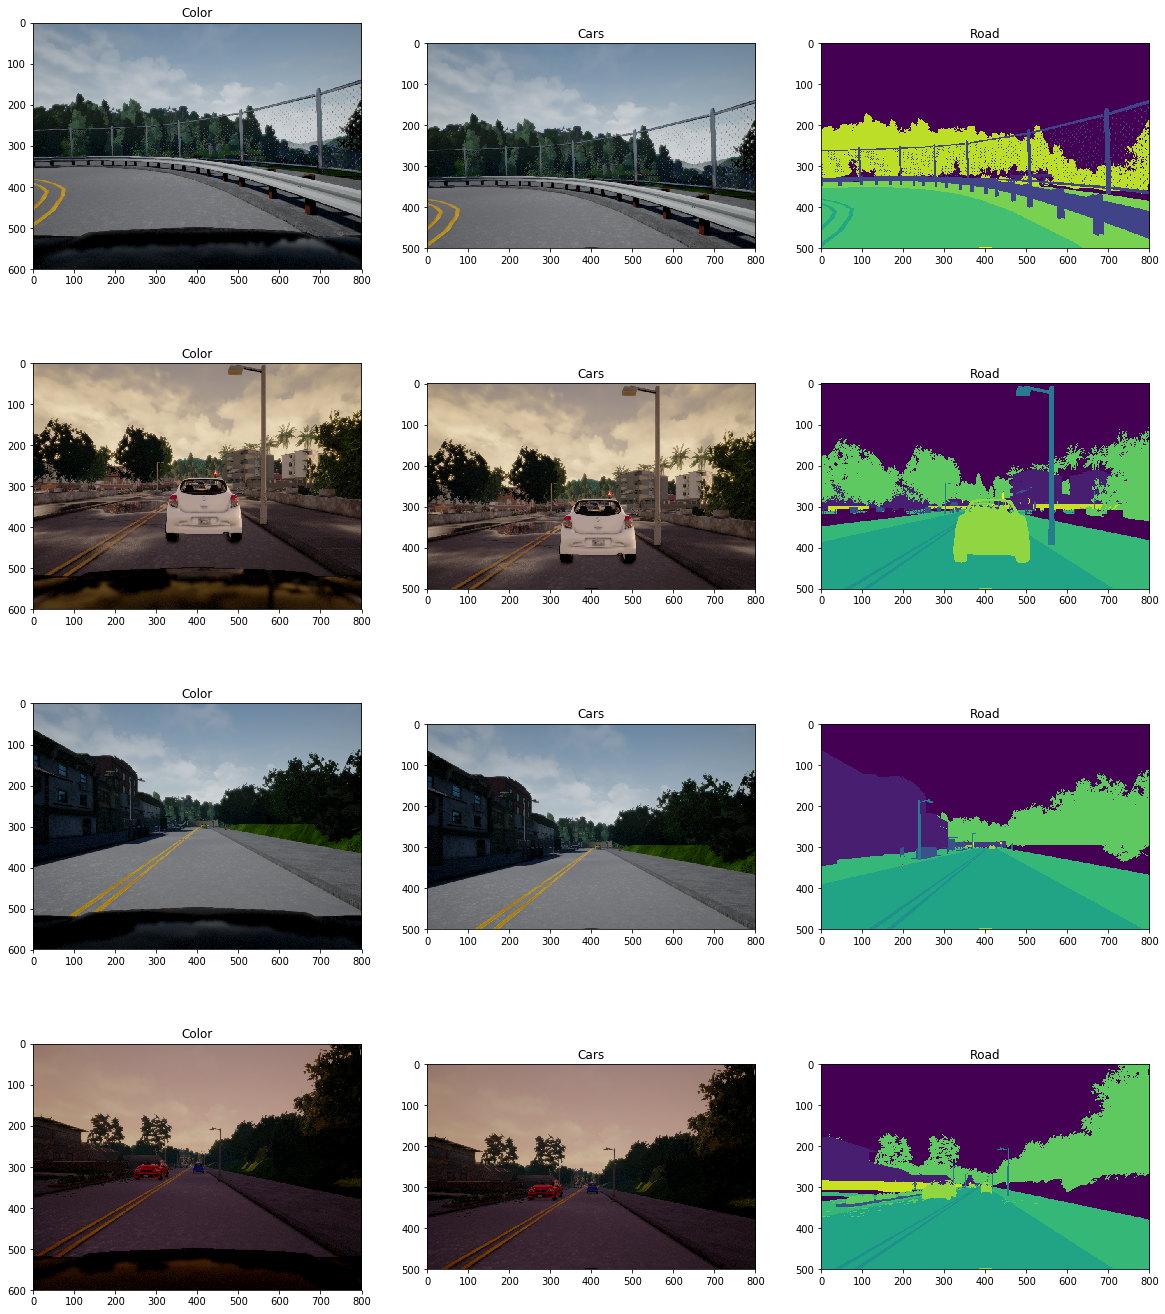

In [14]:
sample_rows = 4
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), (_, c_row) in zip(m_axs, clara_seg_data.sample(sample_rows).iterrows()):
    c_img = imread(c_row['image'])
    
    c_img2 = c_img[:500, :, :]
    l_img = imread(c_row['label'])
    l_img = l_img[:500, :, 0]
    
    lbls = np.zeros_like(l_img)
    lbls[l_img == 10] = 1
    lbls[l_img == 7] = 2
    
    ax1.imshow(c_img)
    ax1.set_title('Color')    
    ax2.imshow(c_img2)
    ax2.set_title('Cars')
    ax3.imshow(l_img)
    ax3.set_title('Road')

In [17]:
IMG_SIZE = (480, 480) # slightly smaller than vgg16 normally expects


def process_label(lbl):
    new_lbl = np.zeros((*IMG_SIZE, 3))
    new_lbl[:, :, 0] = lbl[:, :, 0] == 7
    new_lbl[:400, :, 1] = lbl[:400, :, 0] == 10
    new_lbl[:, :, 2] = np.invert(np.logical_or(new_lbl[:, :, 0], new_lbl[:, :, 1]))
    
    return new_lbl

img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05)



rgb_gen = ImageDataGenerator(preprocessing_function = preprocess_input, **img_gen_args)
lab_gen = ImageDataGenerator(preprocessing_function=process_label, **img_gen_args)

In [18]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])    
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, class_mode = 'sparse',seed = seed,**dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [19]:
def train_and_lab_gen_func(in_df, batch_size = 8, seed = None):
    if seed is None:
        seed = np.random.choice(range(1000))
    
    train_rgb_gen = flow_from_dataframe(rgb_gen, 
                                        in_df, 
                                        path_col = 'image',
                                        y_col = 'id', 
                                        color_mode = 'rgb',
                                        target_size = IMG_SIZE,
                                        batch_size = batch_size,
                                        seed = seed)
    
    train_lab_gen = flow_from_dataframe(lab_gen, 
                                        in_df, 
                                        path_col = 'label',
                                        y_col = 'id', 
                                        target_size = IMG_SIZE,
                                        color_mode = 'rgb',
                                        batch_size = batch_size,
                                        seed = seed)
    
    for (x, _), (y, _) in zip(train_rgb_gen, train_lab_gen):
        yield x, y
    
train_and_lab_gen = train_and_lab_gen_func(train_df, batch_size = 32)
valid_and_lab_gen = train_and_lab_gen_func(valid_df, batch_size = 32)


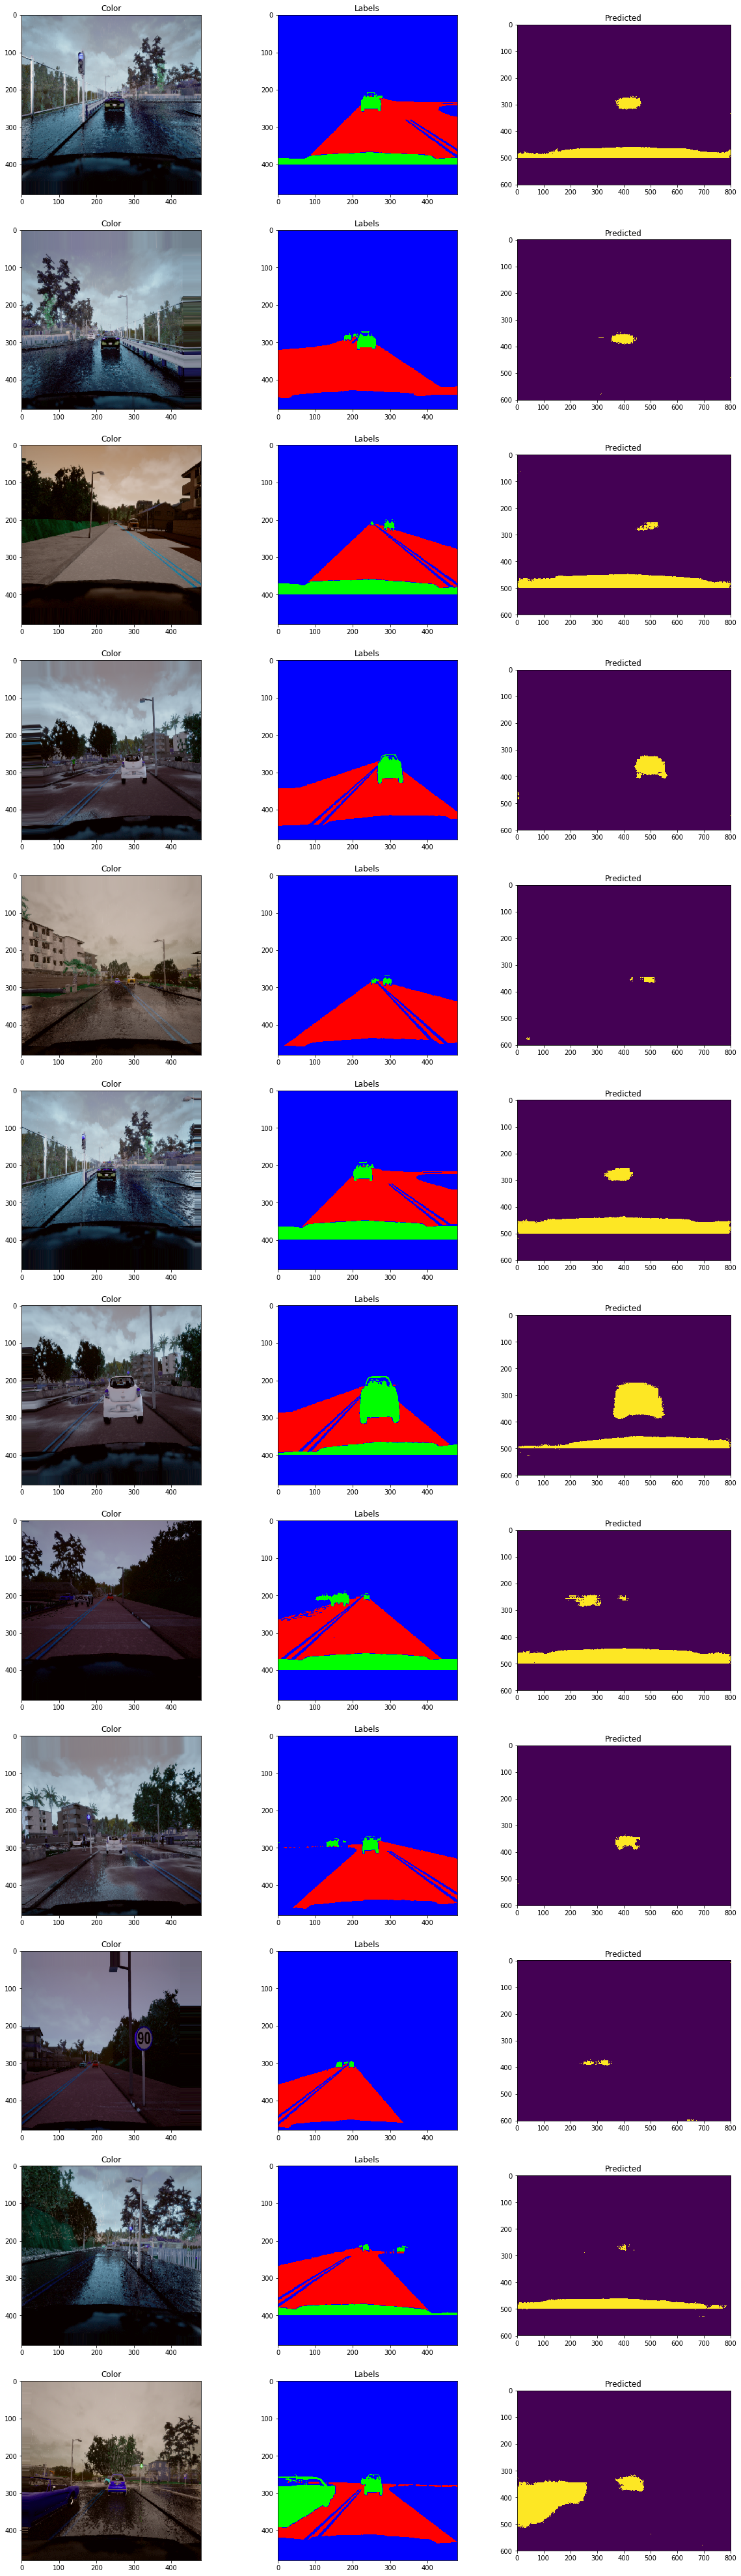

In [29]:
(rgb_batch, lab_batch) = next(valid_and_lab_gen)

sample_rows = 12
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), rgb_img, lab_img in zip(m_axs, rgb_batch, lab_batch):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img+110, 0, 255).astype(np.uint8)
    lab_pred = model.predict(np.expand_dims(rgb_img, 0))[0]
    lab_pred = lab_pred.argmax(axis=2)
    y_pred_color = np.zeros( (480, 480, 3))
    y_pred_color[:, :, 0]  = (lab_pred == 0).astype(np.uint8)
    y_pred_color[:, :, 1]  = lab_pred == 1
    y_pred_color[:, :, 2]  = lab_pred == 2
    y_pred_color = cv2.resize((lab_pred == 1).astype(np.uint8), (800, 600))
    
    ax1.imshow(r_rgb_img)
    ax1.set_title('Color')
    ax2.imshow(lab_img)
    ax2.set_title('Labels')
    ax3.imshow(y_pred_color)
    ax3.set_title('Predicted')